## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.33.1',projectVersion='3.33.1.99999',branch='maurever_PUBDEV-4940_uplift_trees_poc',lastCommitHash='29292b0ad4299eb2f2dbf828b791f5055ed47d17',gitDescribe='jenkins-master-5554-136-g29292b0ad4-dirty',compiledOn='2021-09-26 16:48:18',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters

seed = 1234
ntrees = 100
attempt_per_thread = 6 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024


In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99
                                                )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
max_depths = []

In [6]:
N = 100000
P = 20
max_depth = 8
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [7]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2m_i_rno
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2m_i_rno\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2m_i_rno\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_uftqlb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.45899558067322s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.00104284286499s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.27989912033081s
H2O session _sid_b83c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphzjszm8g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphzjszm8g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphzjszm8g\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,38 minutes
H2O_cluster_name:,H2O_from_python_potte_xwz3oo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.033507347106934s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.697843074798584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.119353532791138s
H2O session _sid_a10b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfmp8y_df
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfmp8y_df\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfmp8y_df\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_vrmjm1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.31971001625061s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.397334575653076s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.135637521743774s
H2O session _sid_9c70 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_gnerqgf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_gnerqgf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_gnerqgf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_0rn036
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.130799770355225s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.172516822814941s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.14608907699585s
H2O session _sid_963a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4wuynpq7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4wuynpq7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4wuynpq7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_j872wl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.97802734375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.307391166687012s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.908963918685913s
H2O session _sid_8975 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp141c2pwj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp141c2pwj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp141c2pwj\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_lgetna
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.48436522483826s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.193304300308228s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.754404067993164s
H2O session _sid_b4d5 closed.
Uplift 45.400900880495705s
RF 11.128238797187805s
gbm 16.390724539756775s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpryr6640k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpryr6640k\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,46 minutes
H2O_cluster_name:,H2O_from_python_potte_77uvke
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.65900111198425s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.086925029754639s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.57610821723938s
H2O session _sid_a1b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk434otry
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk434otry\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk434otry\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_swiwae
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.99253511428833s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.410895347595215s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.259276390075684s
H2O session _sid_bd09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy2d_h7j3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy2d_h7j3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy2d_h7j3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_6z8q51
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 41.47379660606384s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.601191997528076s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.277025699615479s
H2O session _sid_a4c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwaic7f1z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwaic7f1z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwaic7f1z\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_ez3eul
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.04131007194519s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 10.981697082519531s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.458890676498413s
H2O session _sid_a8a8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwp4cdcy_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwp4cdcy_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwp4cdcy_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_dm2wzx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |█████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.41164803504944s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.842278957366943s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.587498903274536s
H2O session _sid_bb74 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9av2vfll
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9av2vfll\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9av2vfll\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,54 minutes
H2O_cluster_name:,H2O_from_python_potte_yef8zq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.98294758796692s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.616553544998169s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.832522869110107s
H2O session _sid_bbda closed.
Uplift 45.09353975454966s
RF 11.423256993293762s
gbm 16.331887125968933s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdgmomxua
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdgmomxua\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_gfuevw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.745084285736084s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.290360689163208s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.12744641304016s
H2O session _sid_a478 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjw4rn3b0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjw4rn3b0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjw4rn3b0\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_60nf0q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.00381064414978s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.690732717514038s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.54217791557312s
H2O session _sid_968d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgi4afe4q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgi4afe4q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgi4afe4q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_7vxmzc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.8033561706543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.342985153198242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.12622356414795s
H2O session _sid_a541 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuq0n6zos
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuq0n6zos\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuq0n6zos\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_us9bjn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.96132469177246s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.317030191421509s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 18.523009538650513s
H2O session _sid_9c22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpws20vn71
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpws20vn71\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpws20vn71\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_cdm7kf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.26514935493469s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.578588008880615s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.87724208831787s
H2O session _sid_a68b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt15rb4i3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt15rb4i3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt15rb4i3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_jm4b1z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.54299974441528s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.264464378356934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.46336007118225s
H2O session _sid_9321 closed.
Uplift 48.886954148610435s
RF 12.747360189755758s
gbm 17.609909931818645s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5eq6slrm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5eq6slrm\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_l5gndo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.30516266822815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.986791849136353s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.633371829986572s
H2O session _sid_8133 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0h0s02jy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0h0s02jy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0h0s02jy\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_t016ca
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.57500982284546s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.085123062133789s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.49546241760254s
H2O session _sid_a4c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfkh5by_f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfkh5by_f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfkh5by_f\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_39zq3b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.135390281677246s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 13.024971008300781s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 17.768916606903076s
H2O session _sid_b0cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4iuf9nj7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4iuf9nj7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4iuf9nj7\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_owgy1d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.94589304924011s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.895158529281616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.46657943725586s
H2O session _sid_941e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyyi9zv09
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyyi9zv09\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyyi9zv09\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_esl5us
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 42.90029215812683s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.861910820007324s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.39974570274353s
H2O session _sid_bdee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1mimkggm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1mimkggm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1mimkggm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_4zzkn9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.00097632408142s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.938395977020264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 15.542225122451782s
H2O session _sid_bf42 closed.
Uplift 45.1437873840332s
RF 12.465391874313354s
gbm 16.551050186157227s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphyevrrt3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphyevrrt3\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_p6d4sg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.869720458984375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.25296664237976s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.540844440460205s
H2O session _sid_8680 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpea_8s95o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpea_8s95o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpea_8s95o\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_1uspyd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.61688280105591s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 11.976430654525757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.448383808135986s
H2O session _sid_a288 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpik_m1rtd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpik_m1rtd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpik_m1rtd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_pd5j6k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.91183042526245s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.92562222480774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.50425386428833s
H2O session _sid_87ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq269vqwo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq269vqwo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq269vqwo\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_ign8gc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.64620113372803s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.083610773086548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.518155336380005s
H2O session _sid_890d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpysp9ik6_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpysp9ik6_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpysp9ik6_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_1ffavd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.72713041305542s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.866628646850586s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.420785427093506s
H2O session _sid_b7cd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsqsnhyoy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsqsnhyoy\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsqsnhyoy\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_5f1ylg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.101409673690796s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 12.226785898208618s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 16.499051570892334s
H2O session _sid_ba15 closed.
Uplift 46.478862484296165s
RF 12.388674139976501s
gbm 16.48857907454173s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsd4ahefw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsd4ahefw\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_9kt1ek
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 68.90800356864929s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.59900140762329s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.40576195716858s
H2O session _sid_a637 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwb_c6o2e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwb_c6o2e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwb_c6o2e\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_fx0zy5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.62815594673157s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.70195508003235s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.365238428115845s
H2O session _sid_b968 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc2bwvv0m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc2bwvv0m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc2bwvv0m\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_vbrrhh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 69.20219874382019s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.74765968322754s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.561267137527466s
H2O session _sid_bdef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp87qrqx04
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp87qrqx04\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp87qrqx04\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_wsztr2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.84540510177612s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.646654844284058s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.296416997909546s
H2O session _sid_af27 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfuxle2v2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfuxle2v2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfuxle2v2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_rkfgo7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 67.77134323120117s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.612467765808105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.367842197418213s
H2O session _sid_9b73 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvtq6bzf0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvtq6bzf0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvtq6bzf0\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_w5nb48
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 69.98054528236389s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.61551547050476s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 24.370484828948975s
H2O session _sid_b294 closed.
Uplift 68.55594197909038s
RF 17.653875708580017s
gbm 24.39450192451477s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps2bx0hcn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps2bx0hcn\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_emksmr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.65291213989258s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.726510286331177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.3250834941864s
H2O session _sid_8698 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph8mx3f7x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph8mx3f7x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph8mx3f7x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_0mhwsx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.91038727760315s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.760831117630005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 43.31821155548096s
H2O session _sid_a0fb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd0ewb2xv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd0ewb2xv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd0ewb2xv\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_t8p4ag
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 115.88699293136597s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.559273958206177s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.49956774711609s
H2O session _sid_9299 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7wvi0qmr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7wvi0qmr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7wvi0qmr\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_phq5s6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 116.77195835113525s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.03646397590637s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 42.544349193573s
H2O session _sid_a0cc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy0pmyjv2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy0pmyjv2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy0pmyjv2\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_fo0xe0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.88469243049622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.7652530670166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.988648891448975s
H2O session _sid_9bee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxniuui87
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxniuui87\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxniuui87\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 hour and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_mzsfhx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.70837950706482s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.54897689819336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.76920509338379s
H2O session _sid_8b1c closed.
Uplift 115.13588710625966s
RF 31.566218217213947s
gbm 42.40751099586487s
12 - Uplift = 45.400900880495705, RF = 11.128238797187805, gbm = 16.390724539756775
10 - Uplift = 45.09353975454966, RF = 11.423256993293762, gbm = 16.331887125968933
8 - Uplift = 48.886954148610435, RF = 12.747360189755758, gbm = 17.609909931818645
6 - Uplift = 45.1437873840332, RF = 12.465391874313354, gbm = 16.551050186157227
4 - Uplift = 46.478862484296165, RF = 12.388674139976501, gbm = 16.48857907454173
2 - Uplift = 6

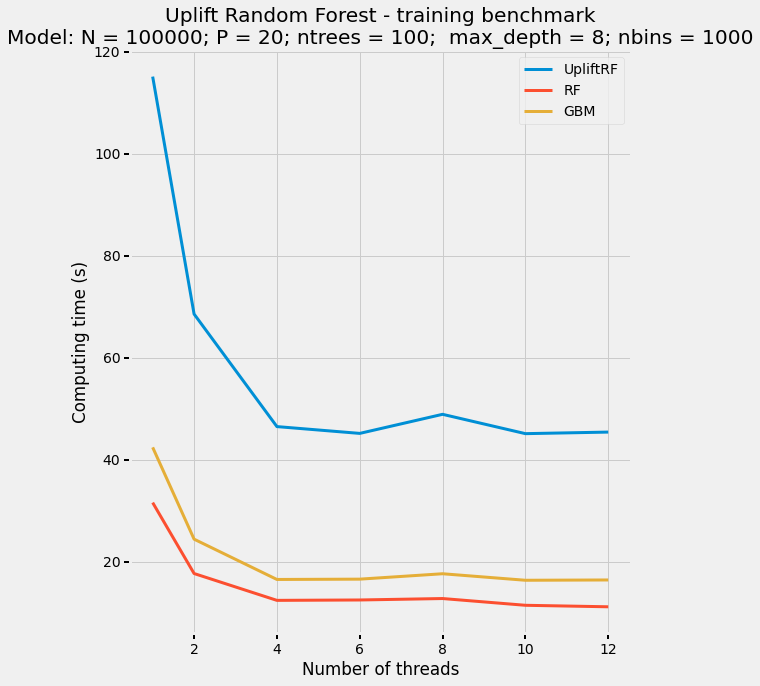

In [8]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [9]:
N = 100000
P = 20
max_depth = 16
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [10]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc6q1iele
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc6q1iele\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc6q1iele\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_gotx1f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 265.8968183994293s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.69121026992798s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 196.34699702262878s
H2O session _sid_8429 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_0_9llpk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_0_9llpk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_0_9llpk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_0n6tm9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 266.2789454460144s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.021648645401s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 199.56473422050476s
H2O session _sid_bad6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7sqrpaph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7sqrpaph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7sqrpaph\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_f2jpfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.4970872402191s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.42098498344421s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.47133016586304s
H2O session _sid_b398 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp11_i82yn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp11_i82yn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp11_i82yn\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_0gjywb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.98687386512756s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.3791344165802s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.81315279006958s
H2O session _sid_9c9d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpn_rot3c2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpn_rot3c2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpn_rot3c2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_e9r660
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 277.9526333808899s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.03007125854492s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 228.83629775047302s
H2O session _sid_8a96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4zrwg_gr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4zrwg_gr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4zrwg_gr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_t0k20z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 276.7650384902954s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.56914830207825s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 229.9606420993805s
H2O session _sid_bb14 closed.
Uplift 271.72956613699597s
RF 87.68536631266277s
gbm 214.4988590081533s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo221j0_4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo221j0_4\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours
H2O_cluster_name:,H2O_from_python_potte_xn3c07
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 263.93780732154846s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.54090714454651s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 184.33490443229675s
H2O session _sid_a674 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmuxuasve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmuxuasve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmuxuasve\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_r9h6cf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 249.56038999557495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 81.35552668571472s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 185.2863187789917s
H2O session _sid_819b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpazvwk33z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpazvwk33z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpazvwk33z\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_r4xy5m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 264.1874294281006s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.86631560325623s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 196.73748779296875s
H2O session _sid_b982 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3qwikwh2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3qwikwh2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3qwikwh2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_0q8wj0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 266.13165616989136s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.2408983707428s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.24093294143677s
H2O session _sid_bedf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxgwenud5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxgwenud5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxgwenud5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_12u9pv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.95025730133057s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.91908264160156s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.50664854049683s
H2O session _sid_9a8a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmuar4yj9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmuar4yj9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmuar4yj9\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_j4w8oi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.6697406768799s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.12687492370605s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 196.47258710861206s
H2O session _sid_90f2 closed.
Uplift 263.2395468155543s
RF 86.17493422826131s
gbm 193.92981326580048s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3dpas3wu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3dpas3wu\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,3 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_91kwcj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.08127307891846s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 78.95122766494751s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 178.08336782455444s
H2O session _sid_a569 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpggmt1g_e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpggmt1g_e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpggmt1g_e\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_v7kgnr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 247.28160619735718s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.96558380126953s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 179.7038872241974s
H2O session _sid_a15a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeh_gjq03
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeh_gjq03\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeh_gjq03\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_desacj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 243.57355284690857s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.64116764068604s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 170.61171317100525s
H2O session _sid_b7ca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwar9frrb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwar9frrb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwar9frrb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_ddnbe2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 233.7287790775299s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.17758178710938s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 178.35444712638855s
H2O session _sid_a706 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplx7v_m5c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplx7v_m5c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplx7v_m5c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_dcraoe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.03479671478271s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.11920142173767s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 182.7837986946106s
H2O session _sid_9cf1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpavdj0qnz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpavdj0qnz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpavdj0qnz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_ucw8xw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 248.7154302597046s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 81.60220718383789s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 182.48335647583008s
H2O session _sid_9ca8 closed.
Uplift 244.0692396958669s
RF 78.07616158326466s
gbm 178.67009508609772s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqq8te0uw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqq8te0uw\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_5okr3o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 234.6158058643341s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.57471299171448s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 167.60212779045105s
H2O session _sid_9df0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ao3vsg1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ao3vsg1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ao3vsg1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,4 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_yhw9r4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 231.6083471775055s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.0455493927002s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 162.19533324241638s
H2O session _sid_8b6c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgs01mnty
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgs01mnty\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgs01mnty\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_drppxg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 229.16642546653748s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.95525169372559s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 159.8905622959137s
H2O session _sid_a69e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnl36cf5s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnl36cf5s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnl36cf5s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_2uye9d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 228.99875569343567s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.1930742263794s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 161.3170518875122s
H2O session _sid_bd72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8udr_ohj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8udr_ohj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8udr_ohj\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_zbcs7l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 227.39025139808655s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.1307053565979s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 158.2180950641632s
H2O session _sid_948d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5_sveanx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5_sveanx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5_sveanx\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mqpord
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 217.2183392047882s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.75808358192444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 152.31059885025024s
H2O session _sid_924e closed.
Uplift 228.16632080078125s
RF 72.94289620717366s
gbm 160.25562818845114s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplp3zvnna
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplp3zvnna\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_4qnh0c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 211.32134819030762s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.2248227596283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.7854118347168s
H2O session _sid_b7eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx7rgu0g_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx7rgu0g_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx7rgu0g_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_q7eod9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 209.23841953277588s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.48766207695007s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.65664434432983s
H2O session _sid_b07f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpckx1bz1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpckx1bz1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpckx1bz1v\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,5 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_1r3i6q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 210.60810160636902s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 68.167325258255s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.44852566719055s
H2O session _sid_a12f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8y24wukm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8y24wukm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8y24wukm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours
H2O_cluster_name:,H2O_from_python_potte_ezugey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 209.7235414981842s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.73261713981628s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.43385791778564s
H2O session _sid_a0fb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl80xt3f1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl80xt3f1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl80xt3f1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_jv4woc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 210.71293711662292s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.7194504737854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.01517581939697s
H2O session _sid_9fb2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkf58a6bv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkf58a6bv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkf58a6bv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_fpwivi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 210.73131489753723s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.90265846252441s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 136.8480634689331s
H2O session _sid_a579 closed.
Uplift 210.38927714029947s
RF 67.53908936182658s
gbm 136.0312798420588s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8ub3_oyz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8ub3_oyz\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_2hu13d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 290.054194688797s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.88660621643066s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 159.18147826194763s
H2O session _sid_b2b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwzpva78a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwzpva78a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwzpva78a\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_ryvayj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 288.1515688896179s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.36891007423401s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 159.35051012039185s
H2O session _sid_9cfe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0iwn7833
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0iwn7833\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0iwn7833\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_n4j29h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 288.1891758441925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.11410522460938s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 160.21115255355835s
H2O session _sid_adff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpckv4nb7u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpckv4nb7u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpckv4nb7u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_yasma3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 286.9173164367676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.38206720352173s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.7409245967865s
H2O session _sid_b28d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqhl1xjyc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqhl1xjyc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqhl1xjyc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,6 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_p39e8g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.9858603477478s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.28423976898193s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 159.8858940601349s
H2O session _sid_9448 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeablkk4l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeablkk4l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeablkk4l\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_o7lo08
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 288.774165391922s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.85528206825256s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 160.10239267349243s
H2O session _sid_ac5b closed.
Uplift 289.01204693317413s
RF 90.98186842600505s
gbm 159.0787253777186s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpehx3wq1m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpehx3wq1m\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_gztgfi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 475.846887588501s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 160.22942185401917s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 236.0629985332489s
H2O session _sid_9957 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpae80t5q4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpae80t5q4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpae80t5q4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_lqiciu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 482.97574496269226s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 161.06395173072815s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.8430619239807s
H2O session _sid_ba0f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphhp_ghpw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphhp_ghpw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphhp_ghpw\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,7 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_y6xrzz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 475.93064880371094s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 158.19079852104187s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.39049744606018s
H2O session _sid_b85c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbmc9ib9b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbmc9ib9b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbmc9ib9b\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_cgxiyl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 474.93339228630066s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 160.92217588424683s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.69793105125427s
H2O session _sid_b9d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphvxf71ae
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphvxf71ae\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphvxf71ae\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_x6kgp3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 477.409218788147s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 160.2454855442047s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.35253500938416s
H2O session _sid_866b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5q1fbyfs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5q1fbyfs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5q1fbyfs\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_cr0l2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 474.811714887619s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 159.81026434898376s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.58263301849365s
H2O session _sid_99d1 closed.
Uplift 476.9846012194951s
RF 160.07701631387076s
gbm 238.98827616373697s
12 - Uplift = 271.72956613699597, RF = 87.68536631266277, gbm = 214.4988590081533
10 - Uplift = 263.2395468155543, RF = 86.17493422826131, gbm = 193.92981326580048
8 - Uplift = 244.0692396958669, RF = 78.07616158326466, gbm = 178.67009508609772
6 - Uplift = 228.16632080078125, RF = 72.94289620717366, gbm = 160.25562818845114
4 - Uplift = 210.38927714029947, RF = 67.53908936182658, gbm = 136.0312798420588
2 - Uplift = 289.01

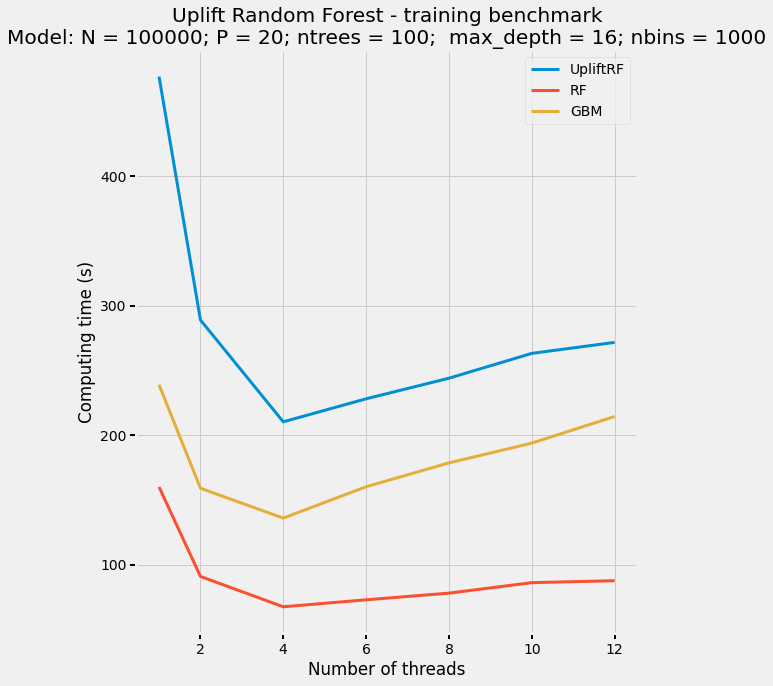

In [11]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [12]:
N = 100000
P = 20
max_depth = 20
max_depths.append(max_depth)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [13]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm54t8xtf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm54t8xtf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm54t8xtf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,8 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_ivveeo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.80447030067444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 103.59294390678406s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.9246790409088s
H2O session _sid_803e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyh31u29k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyh31u29k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyh31u29k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_qvbnn9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 408.3847062587738s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.73926019668579s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.4611213207245s
H2O session _sid_b835 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpawld8jz_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpawld8jz_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpawld8jz_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_aigzvp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 405.34068608283997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.54410457611084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.8794777393341s
H2O session _sid_ba7c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_b87y5c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_b87y5c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_b87y5c\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_302aro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 408.74944376945496s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 102.23314499855042s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 364.3201494216919s
H2O session _sid_855b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphm4g9zon
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphm4g9zon\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphm4g9zon\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,9 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_xoj4jb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.6371774673462s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 103.63916873931885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 367.5476186275482s
H2O session _sid_8714 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4so7oehb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4so7oehb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4so7oehb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_2sircl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 403.7851371765137s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 103.19740319252014s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 365.62784481048584s
H2O session _sid_879b closed.
Uplift 405.6169368426005s
RF 102.99100426832835s
gbm 363.7934818267822s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpft6f9bhg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpft6f9bhg\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_4joobg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.45701789855957s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.83607864379883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 338.60826349258423s
H2O session _sid_8084 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaqgi4uva
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaqgi4uva\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaqgi4uva\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_38gr3n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.2301998138428s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.3951404094696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 337.71796774864197s
H2O session _sid_b4b6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7dasp3mc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7dasp3mc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7dasp3mc\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,10 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_zatc16
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.60053634643555s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.4253101348877s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 336.68894124031067s
H2O session _sid_8534 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoln0rwt0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoln0rwt0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoln0rwt0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours
H2O_cluster_name:,H2O_from_python_potte_uhxjvt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.63203263282776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.0042507648468s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 334.9630744457245s
H2O session _sid_90a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg3cy9dkt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg3cy9dkt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg3cy9dkt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_uwju8t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.9343750476837s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.58987951278687s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 336.3933861255646s
H2O session _sid_a0e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5aef3grk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5aef3grk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5aef3grk\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_dz1ljs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 379.44616436958313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.12882781028748s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 337.6437466144562s
H2O session _sid_abc0 closed.
Uplift 376.3833876848221s
RF 95.22991454601288s
gbm 337.00256327788037s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb_0zucbb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb_0zucbb\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_c0r4ay
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 350.63754868507385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.1847174167633s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 307.45204067230225s
H2O session _sid_9ee4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfpl2xzob
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfpl2xzob\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfpl2xzob\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,11 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_sxf4hs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 354.506370306015s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.90425276756287s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 307.1559216976166s
H2O session _sid_b98c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcqhpwehw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcqhpwehw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcqhpwehw\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_wxjo0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 351.1603548526764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.8723669052124s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 305.37605357170105s
H2O session _sid_97f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphg8cihhu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphg8cihhu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphg8cihhu\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_om0idc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 349.47503781318665s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.33822417259216s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 308.9488151073456s
H2O session _sid_a3fd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz7vzdhqx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz7vzdhqx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz7vzdhqx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_ppff3a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 353.3709306716919s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.76715445518494s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 305.61515712738037s
H2O session _sid_b584 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3m6rdjzd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3m6rdjzd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3m6rdjzd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_td2j99
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 351.16473269462585s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.93524241447449s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 308.4798970222473s
H2O session _sid_af71 closed.
Uplift 351.7191625038783s
RF 86.8336596886317s
gbm 307.1713141997655s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvcwpwdp0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvcwpwdp0\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,12 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_jwqjax
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 328.6908745765686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.18243169784546s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.0462715625763s
H2O session _sid_9832 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr3no6m2k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr3no6m2k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr3no6m2k\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_p68fxm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 331.03161883354187s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.27926468849182s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 278.6466500759125s
H2O session _sid_8558 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgwcp2nez
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgwcp2nez\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgwcp2nez\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_j1mstf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 326.2605845928192s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.9779679775238s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.11861777305603s
H2O session _sid_a1ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg9crh9pk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg9crh9pk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg9crh9pk\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_9c505m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 325.0796992778778s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.06976985931396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 277.8148946762085s
H2O session _sid_8d0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo3xsf10w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo3xsf10w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo3xsf10w\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_ixnnrz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 328.34935235977173s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.3818588256836s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.0388557910919s
H2O session _sid_9977 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp02tgc82n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp02tgc82n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp02tgc82n\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,13 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_jky97f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 327.43274760246277s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.629385471344s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.5849537849426s
H2O session _sid_b609 closed.
Uplift 327.807479540507s
RF 80.42011308670044s
gbm 277.541707277298s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnfe7u9o3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnfe7u9o3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\p

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_9gozx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.31406235694885s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.09388017654419s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.40447402000427s
H2O session _sid_8738 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv8icyepo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv8icyepo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv8icyepo\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_7llq77
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.2682318687439s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.07385301589966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.7778434753418s
H2O session _sid_be94 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_pnssb87
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_pnssb87\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_pnssb87\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_u06ge7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.6878459453583s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.27568078041077s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.87603735923767s
H2O session _sid_aac1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps7lx393h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps7lx393h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps7lx393h\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_lr59ix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.5076003074646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 82.80329012870789s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.40383434295654s
H2O session _sid_b63d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeg0pwrot
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeg0pwrot\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeg0pwrot\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,14 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_wp53d3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.87202644348145s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 80.31777667999268s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.81595754623413s
H2O session _sid_96a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppk92wj09
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppk92wj09\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppk92wj09\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_yuelxw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.4584002494812s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 79.22617888450623s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.6059055328369s
H2O session _sid_a795 closed.
Uplift 312.518027861913s
RF 80.46510994434357s
gbm 243.6473420461019s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_cb5oi4g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_cb5oi4g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_yi5i18
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 413.01759910583496s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 109.72981858253479s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 275.58021354675293s
H2O session _sid_87ee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmzwedk2n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmzwedk2n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmzwedk2n\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_i491dq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 419.2725479602814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 110.27422428131104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.40679001808167s
H2O session _sid_a776 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjwdfo53p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjwdfo53p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjwdfo53p\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_2kkd9x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 419.69950461387634s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.55354237556458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.6128988265991s
H2O session _sid_af97 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphh2lph2r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphh2lph2r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphh2lph2r\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,15 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_0yvi8y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 420.45218086242676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.45052981376648s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 271.40393471717834s
H2O session _sid_bc7a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3uu9lpef
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3uu9lpef\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3uu9lpef\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_z21uer
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 412.1345157623291s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.5395770072937s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.6513760089874s
H2O session _sid_b94e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz7n7s_f5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz7n7s_f5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz7n7s_f5\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_g8slg9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 420.16301822662354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.58647513389587s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 276.44263529777527s
H2O session _sid_b930 closed.
Uplift 417.456561088562s
RF 109.02236119906108s
gbm 272.84964140256244s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqkuwaej4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqkuwaej4\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_ej2tmq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 684.5994880199432s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 193.98034763336182s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 404.2917675971985s
H2O session _sid_826a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqxxl23ph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqxxl23ph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqxxl23ph\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,16 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_wlb2nk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 683.1276950836182s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 195.50423574447632s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 406.454541683197s
H2O session _sid_8729 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3r2wfao8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3r2wfao8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3r2wfao8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_oplai3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 676.0107975006104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 194.8169493675232s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 394.96884655952454s
H2O session _sid_94eb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxhvq1wxh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxhvq1wxh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxhvq1wxh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,17 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_s693rw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 679.2228653430939s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 195.16721963882446s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 404.60513639450073s
H2O session _sid_84c4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfd9wzeli
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfd9wzeli\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfd9wzeli\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_8mf8ho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 675.2460134029388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 192.57483887672424s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 392.1042559146881s
H2O session _sid_8409 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcu7fe20c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcu7fe20c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcu7fe20c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_pvgchj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 683.3615522384644s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 192.1948001384735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 396.13501930236816s
H2O session _sid_a385 closed.
Uplift 680.2614019314448s
RF 194.03973189989725s
gbm 399.7599279085795s
12 - Uplift = 405.6169368426005, RF = 102.99100426832835, gbm = 363.7934818267822
10 - Uplift = 376.3833876848221, RF = 95.22991454601288, gbm = 337.00256327788037
8 - Uplift = 351.7191625038783, RF = 86.8336596886317, gbm = 307.1713141997655
6 - Uplift = 327.807479540507, RF = 80.42011308670044, gbm = 277.541707277298
4 - Uplift = 312.518027861913, RF = 80.46510994434357, gbm = 243.6473420461019
2 - Uplift = 417.45656108856

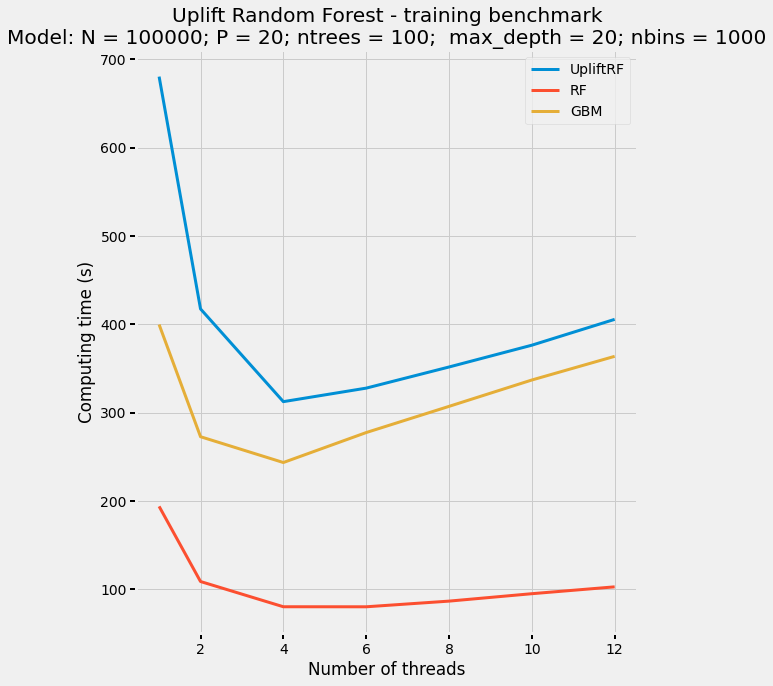

In [14]:
plot_result(uplift_time9, rf_time9, gbm_time9)

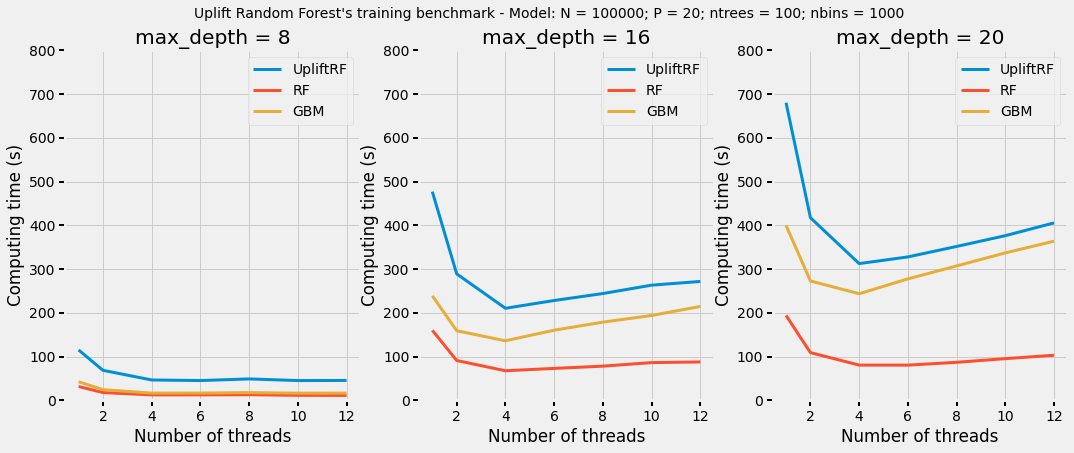

In [15]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [16]:
print(all_predict_uplift)

[{12: 45.400900880495705, 10: 45.09353975454966, 8: 48.886954148610435, 6: 45.1437873840332, 4: 46.478862484296165, 2: 68.55594197909038, 1: 115.13588710625966}, {12: 271.72956613699597, 10: 263.2395468155543, 8: 244.0692396958669, 6: 228.16632080078125, 4: 210.38927714029947, 2: 289.01204693317413, 1: 476.9846012194951}, {12: 405.6169368426005, 10: 376.3833876848221, 8: 351.7191625038783, 6: 327.807479540507, 4: 312.518027861913, 2: 417.456561088562, 1: 680.2614019314448}]


In [17]:
print(all_predict_rf)

[{12: 11.128238797187805, 10: 11.423256993293762, 8: 12.747360189755758, 6: 12.465391874313354, 4: 12.388674139976501, 2: 17.653875708580017, 1: 31.566218217213947}, {12: 87.68536631266277, 10: 86.17493422826131, 8: 78.07616158326466, 6: 72.94289620717366, 4: 67.53908936182658, 2: 90.98186842600505, 1: 160.07701631387076}, {12: 102.99100426832835, 10: 95.22991454601288, 8: 86.8336596886317, 6: 80.42011308670044, 4: 80.46510994434357, 2: 109.02236119906108, 1: 194.03973189989725}]


In [18]:
print(all_predict_gbm)

[{12: 16.390724539756775, 10: 16.331887125968933, 8: 17.609909931818645, 6: 16.551050186157227, 4: 16.48857907454173, 2: 24.39450192451477, 1: 42.40751099586487}, {12: 214.4988590081533, 10: 193.92981326580048, 8: 178.67009508609772, 6: 160.25562818845114, 4: 136.0312798420588, 2: 159.0787253777186, 1: 238.98827616373697}, {12: 363.7934818267822, 10: 337.00256327788037, 8: 307.1713141997655, 6: 277.541707277298, 4: 243.6473420461019, 2: 272.84964140256244, 1: 399.7599279085795}]


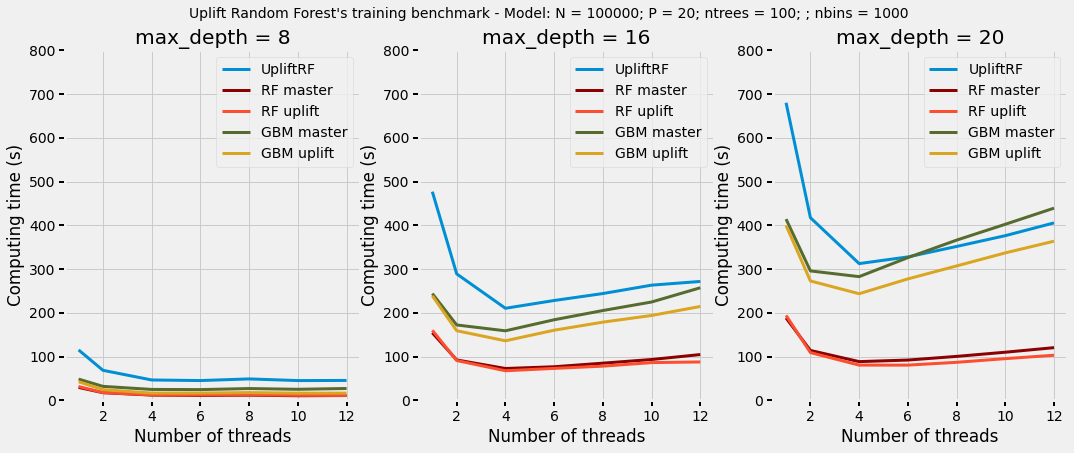

In [19]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 26.986810167630512, 10: 25.17754093805949, 8: 26.859924117724102, 6: 24.445232311884563, 4: 24.84089493751526, 2: 31.85128080844879, 1: 48.42471953233083}, {12: 257.28191316127777, 10: 224.729074438413, 8: 205.23646970589957, 6: 184.1432944138845, 4: 158.8846471707026, 2: 172.22614924112955, 1: 244.03339886665344}, {12: 439.31534298261005, 10: 402.45600994427997, 8: 366.2033998966217, 6: 326.18388803799945, 4: 282.70726378758746, 2: 295.7804197072983, 1: 414.2765694061915}]
all_predict_rf_master = [{12: 10.9469602505366, 10: 10.434547702471415, 8: 11.785475413004557, 6: 11.237413684527079, 4: 11.944405476252237, 2: 17.41841967900594, 1: 29.419774015744526}, {12: 104.57699644565582, 10: 93.2722510099411, 8: 84.90028929710388, 6: 76.68593625227611, 4: 72.69012920061748, 2: 92.24727594852448, 1: 154.36357283592224}, {12: 120.36679824193318, 10: 109.93499068419139, 8: 100.37291808923085, 6: 92.02097642421722, 4: 88.43221167723338, 2: 113.96409718195598, 1: 188.21300756931305}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkolivegreen")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [20]:
nbinss = []

In [21]:
N = 100000
P = 20
max_depth = 16
nbins=20
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [22]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpaztzgskb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpaztzgskb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpaztzgskb\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_17lvkr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.604238748550415s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.424943208694458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.320371389389038s
H2O session _sid_a6f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi0l0wue2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi0l0wue2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi0l0wue2\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_su659e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.990036487579346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.64871382713318s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.443738222122192s
H2O session _sid_82f4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9d7m3qen
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9d7m3qen\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9d7m3qen\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_nnwl02
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.62190270423889s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.055940628051758s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.575973987579346s
H2O session _sid_886a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0al841tp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0al841tp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0al841tp\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_r3bivq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.39505171775818s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.29532289505005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.309327602386475s
H2O session _sid_954b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfb5vtvmh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfb5vtvmh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfb5vtvmh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_y9pntu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.28503727912903s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 22.75984764099121s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.629519939422607s
H2O session _sid_8cda closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplx3qo3__
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplx3qo3__\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplx3qo3__\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,18 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_uy7ukl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.229060888290405s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.527321577072144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.521872997283936s
H2O session _sid_84d7 closed.
Uplift 49.85422130425771s
RF 21.785348296165466s
gbm 27.466800689697266s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc_2e9a5m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc_2e9a5m\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours
H2O_cluster_name:,H2O_from_python_potte_4c884m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.09062576293945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.42153286933899s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.383797883987427s
H2O session _sid_bb5b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_gf8ulfs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_gf8ulfs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_gf8ulfs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_t4zkfm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.93776559829712s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.306764125823975s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.947707176208496s
H2O session _sid_bb76 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd3wljfhb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd3wljfhb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd3wljfhb\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_gaxt96
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.89265441894531s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.294280529022217s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.832671880722046s
H2O session _sid_8be9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp79m_2jg0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp79m_2jg0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp79m_2jg0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_3846tp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.490135192871094s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.988835096359253s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.06255602836609s
H2O session _sid_9acd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8x05qc6o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8x05qc6o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8x05qc6o\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_c2ns2n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.02589273452759s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.10689926147461s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.932206630706787s
H2O session _sid_9271 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0th69gr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0th69gr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0th69gr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_iwsnap
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 49.263755798339844s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.018613815307617s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.312618255615234s
H2O session _sid_8c09 closed.
Uplift 48.95013825098673s
RF 21.18948761622111s
gbm 26.745259642601013s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkgfjx52g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkgfjx52g\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_0mbn9l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.47721004486084s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.927198886871338s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.881853103637695s
H2O session _sid_ae4b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnj0ljqdf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnj0ljqdf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnj0ljqdf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_ub4beo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.677507638931274s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.82916522026062s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.82355308532715s
H2O session _sid_be43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph4k3hbnu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph4k3hbnu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph4k3hbnu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_ng2v2v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.77515649795532s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.955952882766724s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.999903202056885s
H2O session _sid_a257 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpafn0faqo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpafn0faqo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpafn0faqo\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_dy6bhw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.90061593055725s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.507365942001343s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.117780447006226s
H2O session _sid_867b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptwbxp9z3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptwbxp9z3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptwbxp9z3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_fqm96i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.85217595100403s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.69644260406494s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.858052015304565s
H2O session _sid_bece closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf2ovqx36
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf2ovqx36\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf2ovqx36\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_vw2jk8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 48.79439067840576s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 20.947188138961792s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.158734798431396s
H2O session _sid_9039 closed.
Uplift 48.74617612361908s
RF 21.143885612487793s
gbm 25.973312775293987s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3a44jagc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3a44jagc\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_iks70c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.01831912994385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.5011625289917s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.900525331497192s
H2O session _sid_b05e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd_s1pstf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd_s1pstf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd_s1pstf\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_urmtv4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.18136477470398s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.554458379745483s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.891294479370117s
H2O session _sid_8740 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp20pm30pq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp20pm30pq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp20pm30pq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_iql14u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.621176958084106s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.889113426208496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.132721185684204s
H2O session _sid_8bd8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9x7yjvf5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9x7yjvf5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9x7yjvf5\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_nzrosa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.5502507686615s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.87745237350464s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.789239406585693s
H2O session _sid_afd7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwbl5qxhi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwbl5qxhi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwbl5qxhi\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_rju0vs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.267274141311646s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.5734760761261s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.10884714126587s
H2O session _sid_b49e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfd2tllw8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfd2tllw8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfd2tllw8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_i7twz8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 50.50683307647705s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.567618370056152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 27.01208519935608s
H2O session _sid_b613 closed.
Uplift 50.52420314153036s
RF 21.660546859105427s
gbm 26.972452123959858s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf9q_27ay
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf9q_27ay\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_i071tk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.12420105934143s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.085418462753296s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.29279899597168s
H2O session _sid_ae6d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1xh0yxk9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1xh0yxk9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1xh0yxk9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_qlr32y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.15417218208313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.99648094177246s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.696567058563232s
H2O session _sid_888a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3ez770ch
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3ez770ch\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3ez770ch\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_4unxch
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.40913939476013s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 24.95243525505066s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.05263662338257s
H2O session _sid_8bbd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg9vx0r12
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg9vx0r12\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg9vx0r12\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_rfhdyb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.1731333732605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.15781569480896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.17011857032776s
H2O session _sid_939c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptus8vcve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptus8vcve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptus8vcve\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_zunw8v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 58.751182079315186s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.210389137268066s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.57390260696411s
H2O session _sid_8366 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0z_a_bnd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0z_a_bnd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0z_a_bnd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_nh0j5c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 57.230966567993164s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 25.298799753189087s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 30.66561532020569s
H2O session _sid_b1e6 closed.
Uplift 57.47379910945892s
RF 25.116889874140423s
gbm 30.40860652923584s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp257_841_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp257_841_\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ccbte0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 81.95274329185486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.396040201187134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 46.95831918716431s
H2O session _sid_a977 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo_1kxkg3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo_1kxkg3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo_1kxkg3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_iygyff
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 80.84781694412231s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.557700872421265s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 47.29186773300171s
H2O session _sid_b0fb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoy00dz4_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoy00dz4_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoy00dz4_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_w2iv1j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 82.24270224571228s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.31356477737427s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 47.00174355506897s
H2O session _sid_8a7e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9oo_w5_k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9oo_w5_k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9oo_w5_k\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,19 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_6tzgz8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 81.9446611404419s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.300084352493286s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 46.12222671508789s
H2O session _sid_aee6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd91g4y1i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd91g4y1i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd91g4y1i\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_41qn7v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 79.18650770187378s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.24672722816467s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 44.89304280281067s
H2O session _sid_94c0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1a8u9_of
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1a8u9_of\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1a8u9_of\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_3ta2dl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 79.07878112792969s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.444284439086914s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 45.244900703430176s
H2O session _sid_81a9 closed.
Uplift 80.87553540865581s
RF 39.209733645121254s
gbm 46.25201678276062s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpld_q0u5f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpld_q0u5f\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_51nwgh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 130.23293328285217s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.97632837295532s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.6586525440216s
H2O session _sid_86c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbz_qnfnl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbz_qnfnl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbz_qnfnl\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_2utymn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.24201154708862s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.9705605506897s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.66519594192505s
H2O session _sid_b248 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8uopj9n2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8uopj9n2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8uopj9n2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_67pfms
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.78742456436157s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.9805748462677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.92932367324829s
H2O session _sid_998a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp80qygumt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp80qygumt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp80qygumt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_8gr2qx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 135.35546398162842s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 73.13639450073242s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.60749363899231s
H2O session _sid_9cee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp65kurri5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp65kurri5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp65kurri5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_b0l9qc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 132.89689087867737s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 71.63984298706055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.54653549194336s
H2O session _sid_a1d3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuxglg6bh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuxglg6bh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuxglg6bh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_3drb9p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 134.2066147327423s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.18783187866211s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.93798160552979s
H2O session _sid_bd77 closed.
Uplift 133.6202231645584s
RF 73.31525552272797s
gbm 82.05753048261006s
12 - Uplift = 49.85422130425771, RF = 21.785348296165466, gbm = 27.466800689697266
10 - Uplift = 48.95013825098673, RF = 21.18948761622111, gbm = 26.745259642601013
8 - Uplift = 48.74617612361908, RF = 21.143885612487793, gbm = 25.973312775293987
6 - Uplift = 50.52420314153036, RF = 21.660546859105427, gbm = 26.972452123959858
4 - Uplift = 57.47379910945892, RF = 25.116889874140423, gbm = 30.40860652923584
2 - Uplift = 80.8755

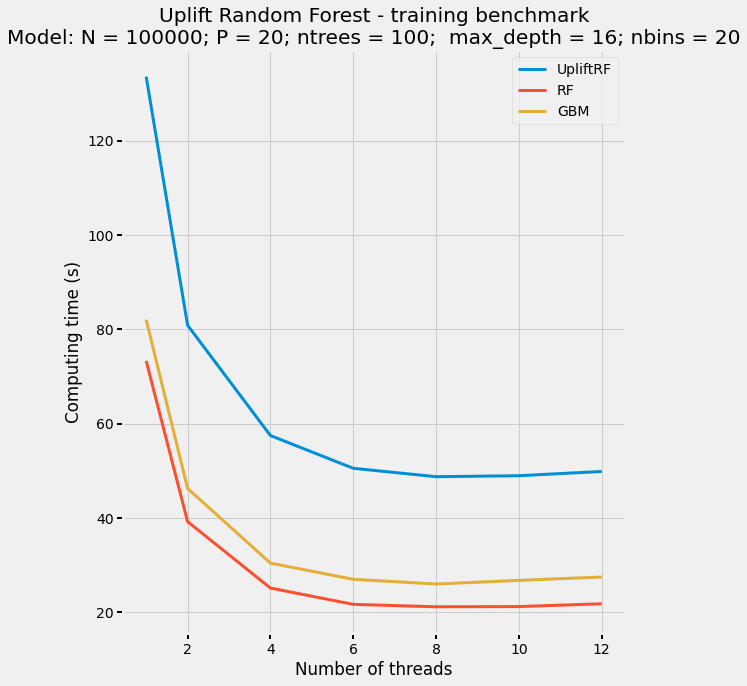

In [23]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [24]:
N = 100000
P = 20
max_depth = 16
nbins=400
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [25]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfc7o9znh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfc7o9znh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfc7o9znh\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_0uks4g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.2355091571808s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 48.80935096740723s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.34255766868591s
H2O session _sid_b666 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6yf9_xad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6yf9_xad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6yf9_xad\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_8jwyu7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.32680201530457s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.10415434837341s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.20185995101929s
H2O session _sid_a080 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp14b6ifhp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp14b6ifhp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp14b6ifhp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_bq0w8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 140.56815600395203s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 46.88694715499878s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.35585451126099s
H2O session _sid_a096 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeqok5w6n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeqok5w6n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeqok5w6n\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,20 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_2oqgjy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 143.12967538833618s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.2056941986084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.71517157554626s
H2O session _sid_8e91 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqdr6mnne
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqdr6mnne\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqdr6mnne\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_9tt1ig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 141.53208589553833s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.999462366104126s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 103.06407642364502s
H2O session _sid_8989 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpus912oxz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpus912oxz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpus912oxz\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_soqdjj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 142.89896178245544s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 47.28168869018555s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 102.0744981765747s
H2O session _sid_a2b1 closed.
Uplift 141.9485317071279s
RF 47.54788295427958s
gbm 102.45900305112202s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpptwim9hn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpptwim9hn\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_thdvyw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 129.91953682899475s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.524434328079224s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 95.10762214660645s
H2O session _sid_830f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpahtm4p6f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpahtm4p6f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpahtm4p6f\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_oyrpcv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 129.69297289848328s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.23231267929077s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 93.31185579299927s
H2O session _sid_9466 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp63obhltz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp63obhltz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp63obhltz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_qv478x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 132.90980315208435s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.26190376281738s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 93.09971618652344s
H2O session _sid_8615 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl3i665c2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl3i665c2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl3i665c2\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_myae0e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 128.53842329978943s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.4233238697052s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 93.96542882919312s
H2O session _sid_991f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjjb2qo4g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjjb2qo4g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjjb2qo4g\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_uzwg32
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 131.25368571281433s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.279072284698486s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 95.8485779762268s
H2O session _sid_a817 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnh988rdu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnh988rdu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnh988rdu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_g4k8v3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 130.11024260520935s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.31417107582092s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 92.88229370117188s
H2O session _sid_bda8 closed.
Uplift 130.4041107495626s
RF 44.339203000068665s
gbm 94.03591577212016s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph8xgwcrc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph8xgwcrc\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_gji03c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.97761034965515s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 41.78592538833618s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.88780617713928s
H2O session _sid_8fab closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxja0ot45
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxja0ot45\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxja0ot45\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_homytx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.12632966041565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 44.524104595184326s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.18212938308716s
H2O session _sid_8d60 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpji24zrqp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpji24zrqp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpji24zrqp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_9djf3y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.43559885025024s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 41.849159717559814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 84.12638998031616s
H2O session _sid_9a96 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuioi4ow_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuioi4ow_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuioi4ow_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 55 minutes
H2O_cluster_name:,H2O_from_python_potte_ekrdl0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 126.78503656387329s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.97071099281311s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.96121001243591s
H2O session _sid_8672 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg4o4xi1e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg4o4xi1e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg4o4xi1e\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,21 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_cg720y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.33305215835571s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 41.88060116767883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.7641053199768s
H2O session _sid_84bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6tobd0jm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6tobd0jm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6tobd0jm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_n3j8a4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.44854855537415s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.78556299209595s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.9997775554657s
H2O session _sid_9a9a closed.
Uplift 123.3510293563207s
RF 41.9660108089447s
gbm 83.4869030714035s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp88jz0lon
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp88jz0lon\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_i4htrm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.0828640460968s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.32982587814331s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 75.69654321670532s
H2O session _sid_8ce3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqnb_iu4g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqnb_iu4g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqnb_iu4g\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_lh1ttb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 117.99350619316101s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.2346727848053s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 76.18962407112122s
H2O session _sid_9a4b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuep1n0j9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuep1n0j9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuep1n0j9\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_tbuzip
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.80654191970825s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.8888213634491s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 76.16734766960144s
H2O session _sid_b776 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphjjl0b40
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphjjl0b40\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphjjl0b40\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_278dl6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.65774583816528s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.83337163925171s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 75.77830696105957s
H2O session _sid_b790 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwty2_osj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwty2_osj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwty2_osj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_ci6orf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 118.0887393951416s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 39.674243450164795s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 76.0878746509552s
H2O session _sid_8c77 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5g7o6ma2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5g7o6ma2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5g7o6ma2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_i4st4n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.55758571624756s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 38.736518144607544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 76.12845420837402s
H2O session _sid_a5e7 closed.
Uplift 118.86449718475342s
RF 39.11624221007029s
gbm 76.00802512963612s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnfdb6ajl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnfdb6ajl\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 34 minutes
H2O_cluster_name:,H2O_from_python_potte_ux4x00
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 125.70861458778381s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 41.97782063484192s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 72.35753512382507s
H2O session _sid_b10d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmeh_cpnz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmeh_cpnz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmeh_cpnz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_eu472e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 122.16660118103027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.542028188705444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 69.61192989349365s
H2O session _sid_8296 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfeaygjd4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfeaygjd4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfeaygjd4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_fntmme
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.15967679023743s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.42646241188049s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 72.10162234306335s
H2O session _sid_926f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoojhqo0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoojhqo0s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoojhqo0s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_u6b24i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.71115493774414s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.5505633354187s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.59045696258545s
H2O session _sid_b542 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz69of8xb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz69of8xb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz69of8xb\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_udal53
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 123.15832090377808s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 40.802225828170776s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.94347786903381s
H2O session _sid_8ee5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpii6dfqn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpii6dfqn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpii6dfqn9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,22 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_f9d5ai
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 124.71540141105652s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 41.820966958999634s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 72.70442271232605s
H2O session _sid_a9db closed.
Uplift 122.76996163527171s
RF 41.02001122633616s
gbm 71.7182408173879s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpesba82a5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpesba82a5\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours
H2O_cluster_name:,H2O_from_python_potte_xzmycs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.20877504348755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.214165449142456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 92.84366035461426s
H2O session _sid_a334 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxopqzof4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxopqzof4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxopqzof4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_53d40j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.91235613822937s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.95158052444458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 94.9086651802063s
H2O session _sid_a276 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkodmij0u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkodmij0u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkodmij0u\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_a1u9x5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.4849009513855s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.094736099243164s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 94.26479911804199s
H2O session _sid_8bca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnvbboo1c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnvbboo1c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnvbboo1c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_hnsgr4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.54112553596497s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.9274160861969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 93.19066286087036s
H2O session _sid_8233 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpye92mpcd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpye92mpcd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpye92mpcd\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_5k4z17
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.76624035835266s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.99510717391968s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 93.51154088973999s
H2O session _sid_bf98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiuza6vh1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiuza6vh1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiuza6vh1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_pphkvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.0284299850464s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.87988829612732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 94.12642979621887s
H2O session _sid_94c6 closed.
Uplift 182.49030466874441s
RF 62.177148938179016s
gbm 93.8076263666153s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy03gdok9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy03gdok9\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_m8dtto
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.053662776947s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.96942830085754s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 149.35395121574402s
H2O session _sid_9fa3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4my_zrpf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4my_zrpf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4my_zrpf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 46 minutes
H2O_cluster_name:,H2O_from_python_potte_wmv8vc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.34579205513s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.98143792152405s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 151.64277148246765s
H2O session _sid_8996 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpai7yh1ev
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpai7yh1ev\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpai7yh1ev\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,23 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_w7vyma
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 313.0197696685791s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.46573805809021s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 146.03180575370789s
H2O session _sid_87ff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm_n0a4a2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm_n0a4a2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm_n0a4a2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5t8qqj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 312.7271227836609s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.90535593032837s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 150.4572491645813s
H2O session _sid_92c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6cgqt7hr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6cgqt7hr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6cgqt7hr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8ruapy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.68519926071167s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.94361853599548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 150.43033647537231s
H2O session _sid_9ba7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq59un9vx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq59un9vx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq59un9vx\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_87lyeq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 314.3543930053711s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.89056420326233s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.01977252960205s
H2O session _sid_a9e1 closed.
Uplift 314.6976565917333s
RF 108.19269049167633s
gbm 150.32264777024588s
12 - Uplift = 141.9485317071279, RF = 47.54788295427958, gbm = 102.45900305112202
10 - Uplift = 130.4041107495626, RF = 44.339203000068665, gbm = 94.03591577212016
8 - Uplift = 123.3510293563207, RF = 41.9660108089447, gbm = 83.4869030714035
6 - Uplift = 118.86449718475342, RF = 39.11624221007029, gbm = 76.00802512963612
4 - Uplift = 122.76996163527171, RF = 41.02001122633616, gbm = 71.7182408173879
2 - Uplift = 182.490304

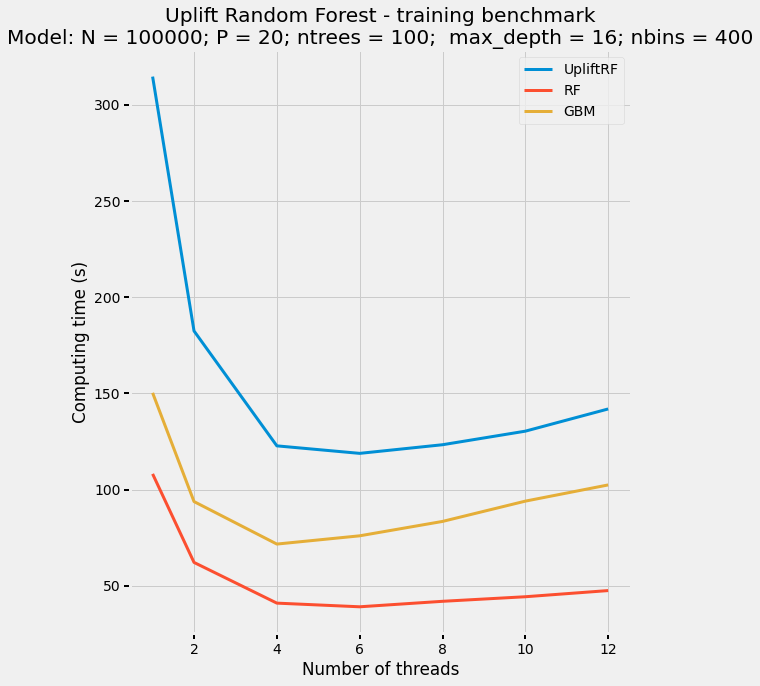

In [26]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [29]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=2000
nbinss.append(nbins)

df, x_names, treatment_column, response_column = syntetic_data(N, P)

In [30]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,17 hours 14 mins
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_r7i6r9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20.10 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 725.9477248191833s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.68851685523987s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 389.6985638141632s
H2O session _sid_995f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqo6tj5h_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqo6tj5h_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqo6tj5h_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1swr0n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 497.26863169670105s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.84708213806152s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 383.49940967559814s
H2O session _sid_aedb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp78ow5dag
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp78ow5dag\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp78ow5dag\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_cij8js
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 499.98040103912354s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 150.14817547798157s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 381.9325156211853s
H2O session _sid_b70c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4pxzo303
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4pxzo303\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4pxzo303\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_41jbjf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 499.6786587238312s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 150.67291069030762s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 375.53937244415283s
H2O session _sid_9420 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps6pvzww5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps6pvzww5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps6pvzww5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_xzt322
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 500.02849888801575s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 150.14352464675903s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 374.90309047698975s
H2O session _sid_b106 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsgpykl6e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsgpykl6e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsgpykl6e\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0ymz8b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 499.24706172943115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 149.31114149093628s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 378.1745116710663s
H2O session _sid_92b3 closed.
Uplift 537.0251628160477s
RF 165.13522521654764s
gbm 380.62457728385925s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp83o6bivl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp83o6bivl\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_pyz7af
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.6196324825287s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 136.79227781295776s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 344.76123428344727s
H2O session _sid_93de closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqra8dltl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqra8dltl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqra8dltl\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tv9vmd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 451.6976420879364s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 136.50031089782715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 349.795348405838s
H2O session _sid_9c89 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5d25d6e_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5d25d6e_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5d25d6e_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_e17gko
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 455.58883571624756s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 135.2022545337677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 347.215607881546s
H2O session _sid_9deb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp362thhjn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp362thhjn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp362thhjn\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3p4zew
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 460.4858295917511s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 137.01036930084229s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 345.80985379219055s
H2O session _sid_97c6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl7gwu3h5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl7gwu3h5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl7gwu3h5\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_j16vwu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 451.82618021965027s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 139.28016543388367s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 347.43657541275024s
H2O session _sid_a119 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2fju044w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2fju044w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2fju044w\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_cgzq2j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.4277534484863s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 136.92863154411316s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 354.23619842529297s
H2O session _sid_83b9 closed.
Uplift 454.4409789244334s
RF 136.95233492056528s
gbm 348.2091363668442s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi3ww69hk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi3ww69hk\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_9m29zw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 406.63906478881836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 125.12123990058899s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 318.5892925262451s
H2O session _sid_8fd8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpij6hdqz6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpij6hdqz6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpij6hdqz6\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_x8x5a2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 398.735826253891s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.59638118743896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 314.00468397140503s
H2O session _sid_81ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5t1bafnd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5t1bafnd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5t1bafnd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_1fc87i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 405.58291149139404s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.91990876197815s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 318.1440670490265s
H2O session _sid_9028 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5mir_7tc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5mir_7tc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5mir_7tc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_d1y1g7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 406.7208023071289s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 125.56744599342346s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 315.1940543651581s
H2O session _sid_9a00 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4zd61xvp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4zd61xvp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4zd61xvp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_8g4ot8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.9056568145752s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.70396780967712s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 319.49335980415344s
H2O session _sid_88f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1x15srwe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1x15srwe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1x15srwe\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_j2xw3u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 402.23190450668335s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 122.66747331619263s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 314.7160646915436s
H2O session _sid_98cf closed.
Uplift 403.4693610270818s
RF 123.59606949488322s
gbm 316.6902537345886s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvumy6wrm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvumy6wrm\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_nmpyj6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 370.86286520957947s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.95331478118896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 279.8518476486206s
H2O session _sid_bded closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpelwwa75h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpelwwa75h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpelwwa75h\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tn2bpb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 369.91193985939026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 115.08877372741699s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 281.73416328430176s
H2O session _sid_9d5c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprpfdtmq6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprpfdtmq6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprpfdtmq6\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_e1bo6a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 372.9119772911072s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.336669921875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 279.4931118488312s
H2O session _sid_af90 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphgeooocb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphgeooocb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphgeooocb\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_avtnsm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 367.63007521629333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 111.43186044692993s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.58235573768616s
H2O session _sid_9ab1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplgsruig1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplgsruig1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplgsruig1\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_u632u3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 370.30801010131836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 113.59545278549194s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.8453805446625s
H2O session _sid_acf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwer8tfvo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwer8tfvo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwer8tfvo\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ckrgtq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 374.2564187049866s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.0838212966919s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.09340953826904s
H2O session _sid_871f closed.
Uplift 370.98021439711255s
RF 112.58164882659912s
gbm 280.7667114337285s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4o__i4o0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4o__i4o0\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_f205jw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 345.92769289016724s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 110.88035154342651s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.00843381881714s
H2O session _sid_9876 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_4jnvi_b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_4jnvi_b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_4jnvi_b\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_5a2tfj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.717387676239s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.91154026985168s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 248.40549445152283s
H2O session _sid_8841 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplerfs9j7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplerfs9j7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplerfs9j7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_dlgc2z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 344.48306488990784s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.72599196434021s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 250.86890149116516s
H2O session _sid_a83e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnwcea_d9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnwcea_d9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnwcea_d9\h2o_potte_started_from_python

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_epf9ss
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 346.7456877231598s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 108.44464826583862s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.03039503097534s
H2O session _sid_b0c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpro1_3z9k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpro1_3z9k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpro1_3z9k\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_13ip44
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.07298946380615s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 109.50216460227966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 247.5130181312561s
H2O session _sid_a26f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqdumk18p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqdumk18p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqdumk18p\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3dcw9y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.2596378326416s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 112.637615442276s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.93496179580688s
H2O session _sid_8d30 closed.
Uplift 347.03441007932025s
RF 109.68371868133545s
gbm 247.62686745325723s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9wnal710
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9wnal710\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_0whkwz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 443.68146109580994s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 142.25981760025024s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 268.977703332901s
H2O session _sid_869e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpozzktta6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpozzktta6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpozzktta6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_zmrzfa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 443.7520422935486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.9278907775879s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.7257709503174s
H2O session _sid_94e1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8y0xgpj0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8y0xgpj0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8y0xgpj0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_yuno83
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 441.98492193222046s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 137.86960411071777s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 272.4995152950287s
H2O session _sid_82a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzsptthhn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzsptthhn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzsptthhn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_tqg394
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 444.10433435440063s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.9774751663208s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 274.56605052948s
H2O session _sid_87d1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzoot8n1v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzoot8n1v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzoot8n1v\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_gdx96p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 434.8054926395416s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 138.02876949310303s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.11754608154297s
H2O session _sid_af09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2mhw6oh_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2mhw6oh_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2mhw6oh_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ai9pz3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 445.45693588256836s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 141.1496729850769s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 269.77629232406616s
H2O session _sid_8d00 closed.
Uplift 442.29753136634827s
RF 139.53553835550943s
gbm 271.1104797522227s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprng2cw9z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprng2cw9z\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_gnspx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 707.5524663925171s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.70130515098572s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 398.78973627090454s
H2O session _sid_a197 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpafn7woqd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpafn7woqd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpafn7woqd\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_kixvxe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 706.4903311729431s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.17112255096436s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 397.6193161010742s
H2O session _sid_8e25 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp19hqrkqg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp19hqrkqg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp19hqrkqg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_qj039l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 701.7016968727112s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 242.64445209503174s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 397.2657036781311s
H2O session _sid_80db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo1rjjg0d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo1rjjg0d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo1rjjg0d\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_h2uk45
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 711.3898088932037s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.9776909351349s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 390.54606318473816s
H2O session _sid_be9f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp246gev9x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp246gev9x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp246gev9x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_3i85xw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 702.145898103714s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 236.7454957962036s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 393.49227929115295s
H2O session _sid_8003 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_wp_jsp6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_wp_jsp6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_wp_jsp6\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.33.1.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_bdc5yt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 710.9972941875458s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 241.31865787506104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 397.16724920272827s
H2O session _sid_a217 closed.
Uplift 706.7129159371058s
RF 240.92645406723022s
gbm 395.8133912881215s
12 - Uplift = 537.0251628160477, RF = 165.13522521654764, gbm = 380.62457728385925
10 - Uplift = 454.4409789244334, RF = 136.95233492056528, gbm = 348.2091363668442
8 - Uplift = 403.4693610270818, RF = 123.59606949488322, gbm = 316.6902537345886
6 - Uplift = 370.98021439711255, RF = 112.58164882659912, gbm = 280.7667114337285
4 - Uplift = 347.03441007932025, RF = 109.68371868133545, gbm = 247.62686745325723
2 - Uplift = 442

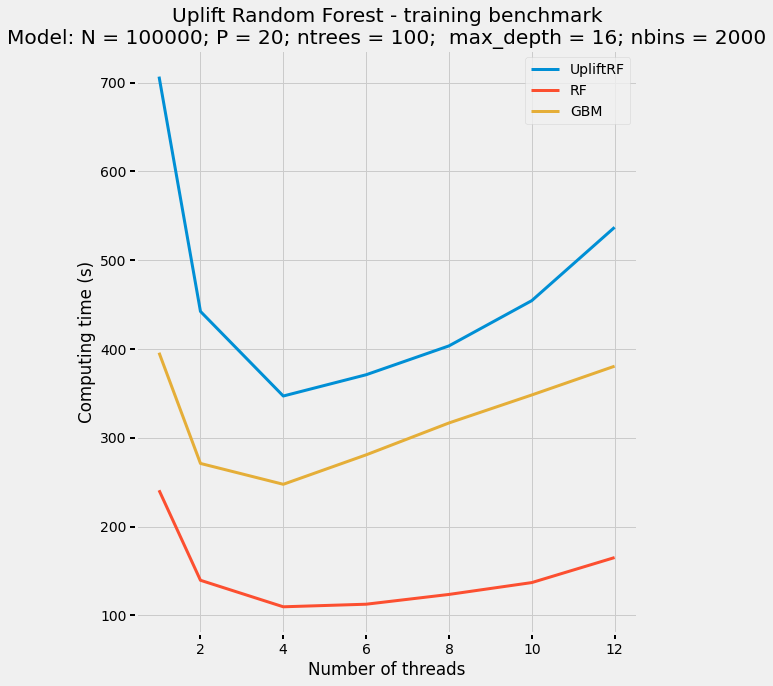

In [31]:
plot_result(uplift_time2, rf_time2, gbm_time2)

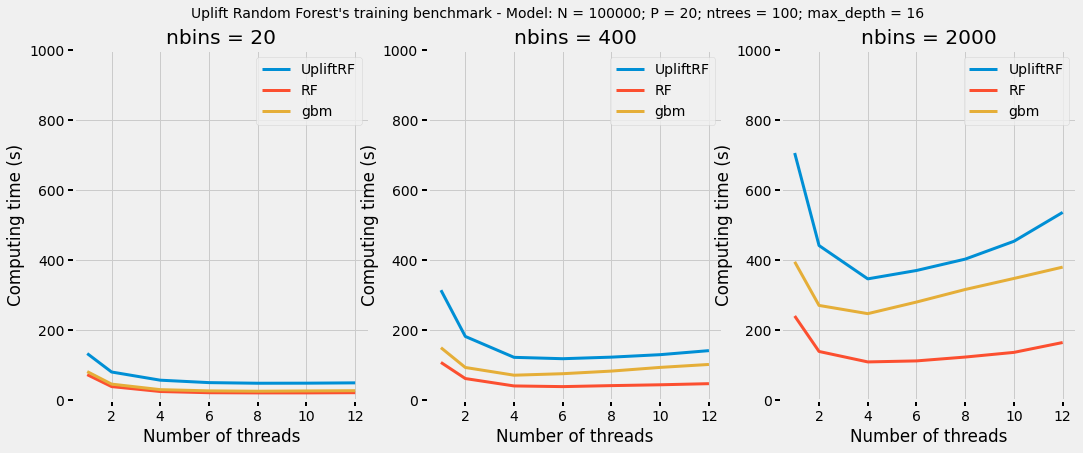

In [32]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [33]:
print(all_predict_uplift)

[{12: 49.85422130425771, 10: 48.95013825098673, 8: 48.74617612361908, 6: 50.52420314153036, 4: 57.47379910945892, 2: 80.87553540865581, 1: 133.6202231645584}, {12: 141.9485317071279, 10: 130.4041107495626, 8: 123.3510293563207, 6: 118.86449718475342, 4: 122.76996163527171, 2: 182.49030466874441, 1: 314.6976565917333}, {12: 537.0251628160477, 10: 454.4409789244334, 8: 403.4693610270818, 6: 370.98021439711255, 4: 347.03441007932025, 2: 442.29753136634827, 1: 706.7129159371058}]


In [34]:
print(all_predict_rf)

[{12: 21.785348296165466, 10: 21.18948761622111, 8: 21.143885612487793, 6: 21.660546859105427, 4: 25.116889874140423, 2: 39.209733645121254, 1: 73.31525552272797}, {12: 47.54788295427958, 10: 44.339203000068665, 8: 41.9660108089447, 6: 39.11624221007029, 4: 41.02001122633616, 2: 62.177148938179016, 1: 108.19269049167633}, {12: 165.13522521654764, 10: 136.95233492056528, 8: 123.59606949488322, 6: 112.58164882659912, 4: 109.68371868133545, 2: 139.53553835550943, 1: 240.92645406723022}]


In [35]:
print(all_predict_gbm)

[{12: 27.466800689697266, 10: 26.745259642601013, 8: 25.973312775293987, 6: 26.972452123959858, 4: 30.40860652923584, 2: 46.25201678276062, 1: 82.05753048261006}, {12: 102.45900305112202, 10: 94.03591577212016, 8: 83.4869030714035, 6: 76.00802512963612, 4: 71.7182408173879, 2: 93.8076263666153, 1: 150.32264777024588}, {12: 380.62457728385925, 10: 348.2091363668442, 8: 316.6902537345886, 6: 280.7667114337285, 4: 247.62686745325723, 2: 271.1104797522227, 1: 395.8133912881215}]


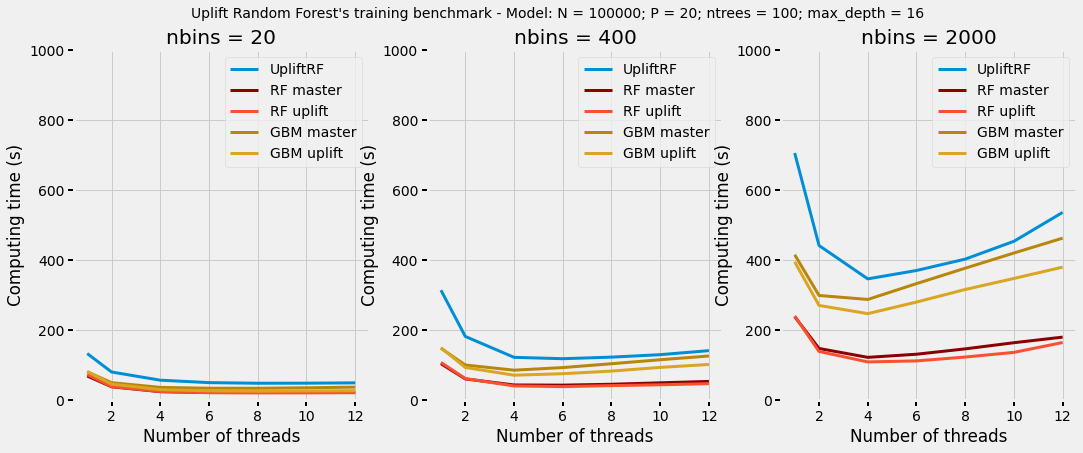

In [36]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 37.61737712224325, 10: 35.763516783714294, 8: 34.403014143308006, 6: 34.46197601159414, 4: 36.87945266564687, 2: 50.39029014110565, 1: 81.316055337588}, {12: 126.65784434477489, 10: 115.9064480861028, 8: 104.52700750033061, 6: 93.53562060991923, 4: 86.0655980904897, 2: 100.8912181854248, 1: 148.63932303587595}, {12: 463.4276549418767, 10: 420.92395985126495, 8: 377.53768213589984, 6: 333.4329918225606, 4: 288.21311410268146, 2: 299.583052833875, 1: 416.0625427166621}]
all_predict_rf_master = [{12: 23.168132662773132, 10: 22.61997667948405, 8: 22.246182600657146, 6: 22.211860140164692, 4: 24.65655283133189, 2: 38.57147363821665, 1: 69.44969248771667}, {12: 53.98993988831838, 10: 49.93324279785156, 8: 45.839822133382164, 6: 43.316195487976074, 4: 43.80987751483917, 2: 61.08458606402079, 1: 104.61950925985973}, {12: 180.5314885377884, 10: 164.58640174070993, 8: 146.99212896823883, 6: 131.66858418782553, 4: 122.71838816006978, 2: 148.0921509663264, 1: 238.9851717154185}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

## Evaluation Stage

In [ ]:
def run_predict(EIF_model, IF_model, hf_test):
    start = time.time()
    EIF_model.predict(hf_test)
    end = time.time()
    eif_time = end - start
    print(f"EIF Time: {eif_time}s")
    start = time.time()
    IF_model.predict(hf_test)
    end = time.time()
    if_time = end - start
    print(f"IF Time: {if_time}s")    
    return eif_time, if_time


def run_predict_benchmark(train_data, test_data):
    all_times = []
    all_times_num_eif = []
    all_times_num_if = []
    for nthreads in threds:
        times_eif = []
        times_if = []
        h2o.init(nthreads=nthreads)     
        hf_train = h2o.H2OFrame(train_data)    
        hf_test = h2o.H2OFrame(test_data)
        EIF_model = H2OExtendedIsolationForestEstimator(model_id = "extended_isolation_forest.hex",
                                             ntrees = ntrees, seed = seed, sample_size = sample_size, extension_level = P - 1)
        EIF_model.train(training_frame = hf_train)
        IF_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                         ntrees = ntrees, seed = seed, sample_size = sample_size, max_depth = max_depth+1)
        IF_model.train(training_frame = hf_train)
        for i in range(attempt_per_thread):
            eif_time, if_time = run_predict(EIF_model, IF_model, hf_test)
            times_eif.append(eif_time)
            times_if.append(if_time)
        h2o.cluster().shutdown()
        print(f"EIF {np.mean(times_eif)}s")
        print(f"IF {np.mean(times_if)}s")
        all_times_num_eif.append(times_eif)
        all_times_num_if.append(times_if)
        all_times.append(f"thread {nthreads} - EIF {np.mean(times_eif)}s and IF {np.mean(times_if)}s")
        
        
    eif_means = dict()
    if_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - EIF = {np.mean(all_times_num_eif[i])}, IF = {np.mean(all_times_num_if[i])}")
        eif_means[nthreads] = np.mean(all_times_num_eif[i])
        if_means[nthreads] = np.mean(all_times_num_if[i])

    return eif_means, if_means 

def plot_predict(EIF_means, IF_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in EIF_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in IF_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="EIF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="IF", linewidth=3)
    # plt.grid("off")
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Extended Isolation Forest - evaluation benchmark\nModel: N = {N_train}; P = {P}; ntrees = {ntrees}; sample_size = {sample_size};  max_depth = {max_depth}\nEvaluation Frame: N = {N}; P = {P}")
    plt.savefig(f"h2o-eval-perf_{sample_size}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()

In [ ]:
# Evaluation stage parameters

N = 500
P = 2
N_train = 500
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time18, if_time18 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time18, if_time18)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 30
N_train = 500_000
sample_size = 256
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time10, if_time10 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time10, if_time10)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 5_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time11, if_time11 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time11, if_time11)

In [ ]:
# Evaluation stage parameters

N = 500_000
P = 40
N_train = 500_000
sample_size = 20_000
max_depth = math.ceil(math.log(sample_size, 2))

blobs_params = dict(random_state=seed, n_samples=N_train, n_features=P)
X_train = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

blobs_params = dict(random_state=seed, n_samples=N, n_features=P)
X_test = make_blobs(centers=[[0 for i in range(P)] for i in range(P)], cluster_std=1, **blobs_params)[0]

eif_time12, if_time12 = run_predict_benchmark(X_train, X_test)

In [ ]:
plot_predict(eif_time12, if_time12)

### Real Credit Card Fraud Detection Data

In [ ]:
sample_sizes = []

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = 256
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time14, if_time14 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time14, if_time14)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.01)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time15, if_time15 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time15, if_time15)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.05)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time16, if_time16 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time16, if_time16)

In [ ]:
# Evaluation stage parameters

# Real data parameters

df = pd.read_csv("../creditcard.csv", nrows=1)
columns = df.columns.tolist()
cols_to_use = columns[:len(columns)-1]
df = pd.read_csv("../creditcard.csv", usecols=cols_to_use)

N = df.shape[0]
N_train = df.shape[0]
P = df.shape[1]
sample_size = int(df.shape[0] * 0.10)
sample_sizes.append(sample_size)
max_depth = math.ceil(math.log(sample_size, 2))

print(N, P, sample_size, max_depth)

eif_time17, if_time17 = run_predict_benchmark(df, df)

In [ ]:
plot_predict(eif_time17, if_time17)

In [ ]:
all_predict_eif = [eif_time14, eif_time15, eif_time16]
all_predict_if = [if_time14, if_time15, if_time16]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Extended Isolation Forest's scoring benchmark - Frame to score: N = {N}; P = {P}. Model: N = {N_train}; P = {P}; ntrees = {ntrees}.", fontsize=14)

for eif_time, if_time, i in zip(all_predict_eif, all_predict_if, range(1, len(sample_sizes) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"EIF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in if_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"IF", linewidth=3)    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 40)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"sample_size = {sample_sizes[i - 1]}; max_depth = {math.ceil(math.log(sample_sizes[i - 1], 2))}")

plt.savefig(f"h2o-score-perf_credit{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()